# Modelowanie wartości odszkodowań

### Estymowanie metodą estymatora największej wiarogodności

In [32]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random

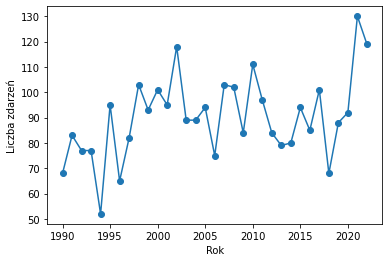

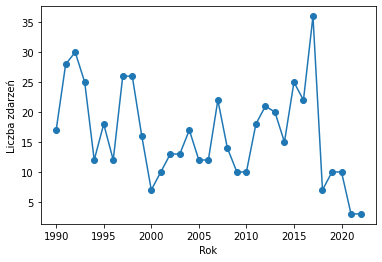

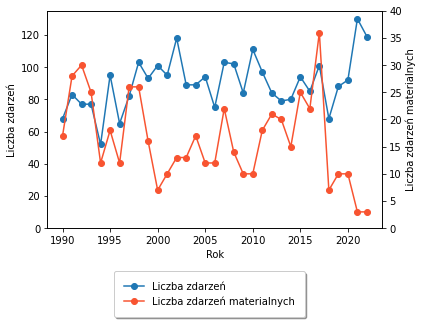

C:\Users\ndzad\AppData\Local\Temp/ipykernel_30224/3110197025.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


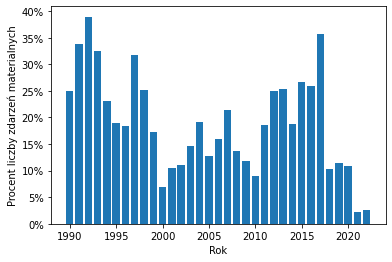

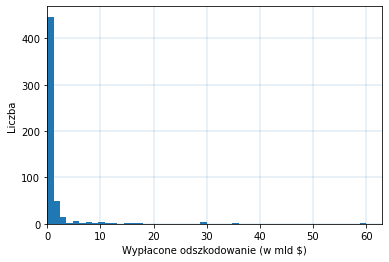

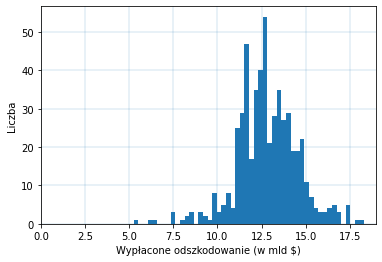

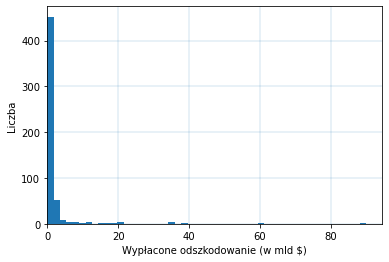

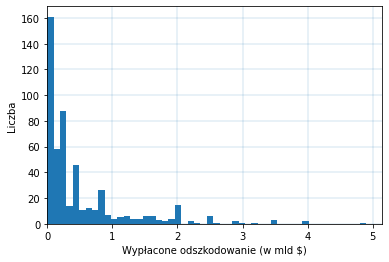

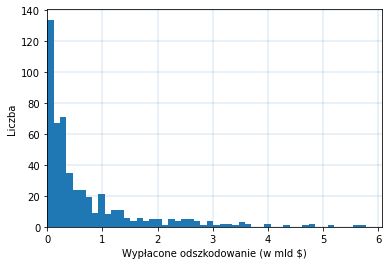

In [33]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\DataPreparation.ipynb"

In [34]:
X = train["Insured Damages, Adjusted (\'000 US$)"]

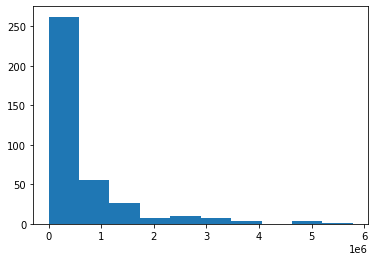

In [35]:
plt.hist(X)
plt.show()

#### Rozkład wykładniczy

$\hat{\lambda}=\frac{n}{\sum\limits_{i=1}^n x_i}$

In [36]:
exp_lambda = len(X)/sum(X)
print(round(exp_lambda,9))

1.667e-06


In [37]:
1/stats.expon.fit(X,floc=0)[1] #Wynik z biblioteki floc to parametr polozenia

1.667487589334536e-06

In [38]:
exp_res = stats.kstest(X, stats.expon(scale=1/exp_lambda).cdf)
exp_res.pvalue

6.769813434250157e-11

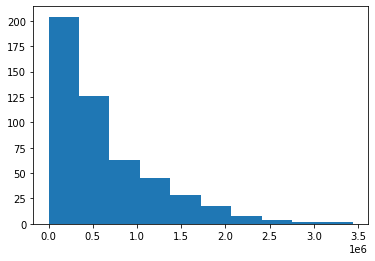

In [39]:
plt.hist(stats.expon.rvs(scale=1/exp_lambda,loc=0,size=500))
plt.show()

Testy

In [40]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy'],
    'test': ['KS','CM'],
    'Wartość statystyki' : [round(stats.kstest(X, stats.expon(scale=1/lambda_hat,loc=0).cdf)[0],2),round(stats.cramervonmises(X, stats.expon(scale=1/exp_lambda,loc=0).cdf).statistic,2)],
    'p value' : [stats.kstest(X, stats.expon(scale=1/lambda_hat,loc=0).cdf)[1],stats.cramervonmises(X, stats.expon(scale=1/exp_lambda,loc=0).cdf).pvalue]
}))

       rozkład test  Wartość statystyki       p value
0  Wykładniczy   KS                0.18  6.769813e-11
1  Wykładniczy   CM                3.06  5.051111e-08


#### Rozkład lognormalny

$\hat{\mu} = \frac{\sum\limits_{i=1}^n\ln x_i}{n}
\\
\hat{\sigma}^2 = \frac{\sum\limits_{i=1}^n\left(\ln x_i-\frac{\sum_{i=1}^n\ln x_i}{n}\right)^2}{n}$

In [41]:
ln_mu = sum(np.log(X))/len(X)
ln_sigma_sq = sum(np.square(np.log(X)-mu_hat))/len(X)
print(round(ln_mu,2),round(sigma_sq_hat,2))

12.47 2.07


In [42]:
#Z dokumentacji "Suppose a normally distributed random variable X has mean mu and standard deviation sigma. Then Y = exp(X) is lognormally distributed with s = sigma and scale = exp(mu)."

print(np.log(stats.lognorm.fit(X,floc=0)[2]), np.square(stats.lognorm.fit(X,floc=0)[0]))

12.46672547764283 2.074318127197053


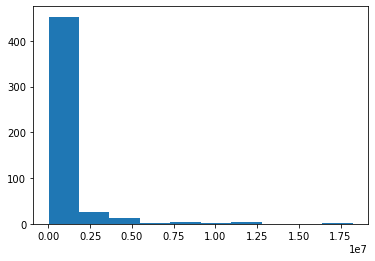

In [43]:
plt.hist(stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq),scale=np.exp(ln_mu),size=500))
plt.show()

Testy

In [44]:
print(pd.DataFrame
({
    'rozkład':['Lognormalny','Lognormalny'],
    'test': ['KS','CM'],
    'Wartość statystyki' : [round(stats.kstest(X, stats.lognorm(np.sqrt(ln_sigma_sq),0,np.exp(ln_mu)).cdf)[0],2),round(stats.cramervonmises(X, stats.lognorm(np.sqrt(ln_sigma_sq),0,np.exp(ln_mu)).cdf).statistic,2)],
    'p value' : [stats.kstest(X, stats.lognorm(np.sqrt(ln_sigma_sq),0,np.exp(ln_mu)).cdf)[1],stats.cramervonmises(X, stats.lognorm(np.sqrt(ln_sigma_sq),0,np.exp(ln_mu)).cdf).pvalue]
}))

       rozkład test  Wartość statystyki   p value
0  Lognormalny   KS                0.06  0.120754
1  Lognormalny   CM                0.21  0.244276


#### Rozkład gamma

$\hat{\lambda}=\left(\frac{1}{n}\displaystyle{\sum_{i=1}^n}x_i^{\hat{k}}\right)^{\frac{1}{\hat{k}}}
\\
\hat{k}=\frac{n}{\frac{1}{\hat{\lambda}}\displaystyle{\sum_{i=1}^{n}}x_i^{\hat{k}}\ln x_i-\displaystyle{\sum_{i=1}^{n}}\ln x_i}$

In [45]:
from scipy.special import digamma, gamma

In [46]:
import numpy as np
from scipy.special import digamma, gamma, polygamma

def gamma_mle(data):
    """Funkcja oblicza estymator największej wiarygodności dla rozkładu gamma."""
    n = len(data)
    s = np.log(np.mean(data)) - np.mean(np.log(data))
    r = np.log(n) - np.sum(digamma(data)) / n
    x0 = np.array([s, r])

    # Definicja funkcji i pochodnej log-likelihood dla rozkładu gamma
    def loglik(theta):
        return n * (theta[1] * np.log(theta[0]) - gamma(theta[1]) + (theta[1] - 1) * np.mean(np.log(data))) + n * np.log(gamma(theta[1]))

    def dloglik(theta):
        d1 = n * (np.log(theta[0]) - digamma(theta[1]))
        d2 = n * (theta[1] / theta[0] - np.mean(np.log(data)) + np.log(theta[0]) - polygamma(0, theta[1]))
        return np.array([d1, d2])

    # Implementacja algorytmu Newtona-Raphsona
    tol = 1e-6
    max_iter = 100
    iter = 0
    diff = tol + 1
    while iter < max_iter and diff > tol:
        theta = x0 - np.linalg.inv(hessian(x0, dloglik)) @ dloglik(x0)
        diff = np.linalg.norm(theta - x0)
        x0 = theta
        iter += 1

    return x0[0], x0[1]

def hessian(x, f):
    """Funkcja oblicza hesjan dla funkcji f w punkcie x."""
    n = len(x)
    hess = np.zeros((n, n))
    eps = 1e-6
    for i in range(n):
        for j in range(i, n):
            e_i = np.zeros(n)
            e_j = np.zeros(n)
            e_i[i] = eps
            e_j[j] = eps
            hess[i, j] = (f(x + e_i + e_j) - f(x + e_i) - f(x + e_j) + f(x)) / (eps ** 2)
            hess[j, i] = hess[i, j]
    return hess


In [47]:
from scipy.optimize import anderson
from scipy.special import psi

In [48]:
gamma_alfa = stats.gamma.fit(X,floc=0)[0]
gamma_beta = 1/stats.gamma.fit(X,floc=0)[2]
print(round(gamma_alfa,2),gamma_beta)

0.72 1.1988586302925719e-06


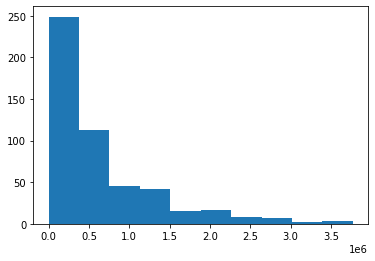

In [49]:
plt.hist(stats.gamma.rvs(a=gamma_alfa,scale=1/gamma_beta,size=500))
plt.show()

Testy

In [50]:
print(pd.DataFrame
({
    'rozkład':['Gamma','Gamma'],
    'test': ['KS','CM'],
    'Wartość statystyki' : [round(stats.kstest(X, stats.gamma(a=gamma_alfa,scale=1/gamma_beta).cdf)[0],2),round(stats.cramervonmises(X, stats.gamma(a=gamma_alfa,scale=1/gamma_beta).cdf).statistic,2)],
    'p value' : [stats.kstest(X, stats.gamma(a=gamma_alfa,scale=1/gamma_beta).cdf)[1],stats.cramervonmises(X, stats.gamma(a=gamma_alfa,scale=1/gamma_beta).cdf).pvalue]
}))

  rozkład test  Wartość statystyki   p value
0   Gamma   KS                0.13  0.000012
1   Gamma   CM                1.02  0.002138


#### Rozkład Weibulla

$\hat{\lambda}=\left(\frac{1}{n}\displaystyle{\sum_{i=1}^n}x_i^{\hat{k}}\right)^{\frac{1}{\hat{k}}}
\\
\hat{k}=\frac{n}{\frac{1}{\hat{\lambda}}\displaystyle{\sum_{i=1}^{n}}x_i^{\hat{k}}\ln x_i-\displaystyle{\sum_{i=1}^{n}}\ln x_i}$

In [51]:
weibull_k = stats.weibull_min.fit(X,floc=0)[0]
weibull_lambda = stats.weibull_min.fit(X,floc=0)[2]
print(weibull_k,weibull_lambda)

0.786188921301622 514170.5554941683


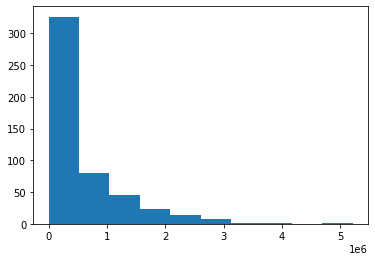

In [52]:
plt.hist(stats.weibull_min.rvs(c=weibull_k,scale=weibull_lambda,size=500))
plt.show()

Testy

In [53]:
print(pd.DataFrame
({
    'rozkład':['Weibulla','Weibulla'],
    'test': ['KS','CM'],
    'Wartość statystyki' : [round(stats.kstest(X, stats.weibull_min(c=weibull_k,scale=weibull_lambda).cdf)[0],2),round(stats.cramervonmises(X, stats.weibull_min(c=weibull_k,scale=weibull_lambda).cdf).statistic,2)],
    'p value' : [stats.kstest(X, stats.weibull_min(c=weibull_k,scale=weibull_lambda).cdf)[1],stats.cramervonmises(X, stats.weibull_min(c=weibull_k,scale=weibull_lambda).cdf).pvalue]
}))

    rozkład test  Wartość statystyki   p value
0  Weibulla   KS                0.10  0.001004
1  Weibulla   CM                0.59  0.023748


#### Rozkład Burra

In [54]:
from scipy.special import beta

In [55]:
burr_c = stats.burr12.fit(X,floc=0,fscale=1)[0]
burr_k = stats.burr12.fit(X,floc=0,fscale=1)[1]
print(burr_c,burr_k)

c:\Users\ndzad\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


1.861639368063435 0.043086409391061675


Testy

In [56]:
print(pd.DataFrame
({
    'rozkład':['Burra','Burra'],
    'test': ['KS','CM'],
    'Wartość statystyki' : [round(stats.kstest(X, stats.burr12(c=burr_c,d=burr_k).cdf)[0],2),round(stats.cramervonmises(X, stats.burr12(c=burr_c,d=burr_k).cdf).statistic,2)],
    'p value' : [stats.kstest(X, stats.burr12(c=burr_c,d=burr_k).cdf)[1],stats.cramervonmises(X, stats.burr12(c=burr_c,d=burr_k).cdf).pvalue]
}))

  rozkład test  Wartość statystyki       p value
0   Burra   KS                0.51  4.854888e-90
1   Burra   CM               29.38  4.346694e-09


### Wyniki

In [57]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy','Lognormalny','Lognormalny','Gamma','Gamma','Weibulla','Weibulla','Burra','Burra'],
    'test': ['KS','CM','KS','CM','KS','CM','KS','CM','KS','CM'],
    'Wartość statystyki' : [
                            round(stats.kstest(X, stats.expon(scale=1/exp_lambda,loc=0).cdf)[0],2),round(stats.cramervonmises(X, stats.expon(scale=1/exp_lambda,loc=0).cdf).statistic,2),
                            round(stats.kstest(X, stats.lognorm(np.sqrt(ln_sigma_sq),0,np.exp(ln_mu)).cdf)[0],2),round(stats.cramervonmises(X, stats.lognorm(np.sqrt(ln_sigma_sq),0,np.exp(ln_mu)).cdf).statistic,2),
                            round(stats.kstest(X, stats.gamma(a=gamma_alfa,scale=1/gamma_beta).cdf)[0],2),round(stats.cramervonmises(X, stats.gamma(a=gamma_alfa,scale=1/gamma_beta).cdf).statistic,2),
                            round(stats.kstest(X, stats.weibull_min(c=weibull_k,scale=weibull_lambda).cdf)[0],2),round(stats.cramervonmises(X, stats.weibull_min(c=weibull_k,scale=weibull_lambda).cdf).statistic,2),
                            round(stats.kstest(X, stats.burr12(c=burr_c,d=burr_k).cdf)[0],2),round(stats.cramervonmises(X, stats.burr12(c=burr_c,d=burr_k).cdf).statistic,2)
                            ],
    'p value' : [
        stats.kstest(X, stats.expon(scale=1/exp_lambda,loc=0).cdf)[1],stats.cramervonmises(X, stats.expon(scale=1/exp_lambda,loc=0).cdf).pvalue,
        stats.kstest(X, stats.lognorm(np.sqrt(ln_sigma_sq),0,np.exp(ln_mu)).cdf)[1],stats.cramervonmises(X, stats.lognorm(np.sqrt(ln_sigma_sq),0,np.exp(ln_mu)).cdf).pvalue,
        stats.kstest(X, stats.gamma(a=gamma_alfa,scale=1/gamma_beta).cdf)[1],stats.cramervonmises(X, stats.gamma(a=gamma_alfa,scale=1/gamma_beta).cdf).pvalue,
        stats.kstest(X, stats.weibull_min(c=weibull_k,scale=weibull_lambda).cdf)[1],stats.cramervonmises(X, stats.weibull_min(c=weibull_k,scale=weibull_lambda).cdf).pvalue,
        stats.kstest(X, stats.burr12(c=burr_c,d=burr_k).cdf)[1],stats.cramervonmises(X, stats.burr12(c=burr_c,d=burr_k).cdf).pvalue
        ]
}))

       rozkład test  Wartość statystyki       p value
0  Wykładniczy   KS                0.18  6.769813e-11
1  Wykładniczy   CM                3.06  5.051111e-08
2  Lognormalny   KS                0.06  1.207536e-01
3  Lognormalny   CM                0.21  2.442758e-01
4        Gamma   KS                0.13  1.164551e-05
5        Gamma   CM                1.02  2.137666e-03
6     Weibulla   KS                0.10  1.004223e-03
7     Weibulla   CM                0.59  2.374758e-02
8        Burra   KS                0.51  4.854888e-90
9        Burra   CM               29.38  4.346694e-09
